# G: Explain Models

## imports

In [1]:


import copy
import pandas as pd

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
import numpy as np
import mlflow
from patsy import dmatrices  # for formula parsing

import json  # for reading signature

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from sklearn.datasets import fetch_openml
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import PoissonRegressor, GammaRegressor
from sklearn.linear_model import TweedieRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer

import h2o

import shap
from datetime import datetime
import os

import importlib
import re
import pickle
import dill

## INPUT 

In [2]:
# runid = '1b6b96ef3cb14b93b60af5f2a84eeb94'
# mlflow.set_tracking_uri('')

# Research tracking
runid = "072bc1fb2d3e4569b64f372991d68e5f"
mlflow_tracking_uri = "file:D:/Stuff/OneDrive/MLflow"
mlflow.set_tracking_uri(mlflow_tracking_uri)

experiment_name = "P1-AnalyzeTrades_f_core"

mlflow.set_experiment(experiment_name)
experiment_details = mlflow.get_experiment_by_name(experiment_name)

In [3]:
## pull information

XY_df = pd.read_csv("output/e_resultcleaned.csv")
XY_df["weight"] = 1

In [4]:
## pull information from mlflow and decide model type

# TODO H2O signature missing

mlflow.end_run()
mlflow.start_run(run_id=runid)


def parse_mlflow_info(run_info):
    metrics = run_info.data.metrics
    params = run_info.data.params
    tags = run_info.data.tags
    return metrics, params, tags


metrics, params, tags = parse_mlflow_info(mlflow.get_run(runid))

mlflow.end_run()

formula_clean = params["formula"].replace("\n", "")

model_type = "general"
if "h2o" in str(json.loads(tags["mlflow.log-model.history"])[0]["flavors"]).lower():
    model_type = "h2o"
    print(f"model type is {model_type}")

In [5]:
## pull model from tracking uri

# tracking_uri = mlflow.get_tracking_uri()

artifact_loc = (
    str(experiment_details.artifact_location)
    .replace("file:", "")
    .replace("file:", "")
    .replace("///", "")
)

# try pickle first, otherwise try H2O
if model_type == "h2o":
    # for h2o models
    # h2o.init()
    # mdl = h2o.import_mojo(f'{artifact_loc}/{runid}/artifacts/')
    logged_model = f"runs:/{runid}/model"
    mdl = mlflow.pyfunc.load_model(logged_model)

else:
    mdl = pickle.load(open(f"{artifact_loc}/{runid}/artifacts/model/model.pkl", "rb"))

In [6]:
## parse data

mlflow.end_run()
mlflow.start_run(run_id=runid)

if len(formula_clean) > 1:
    y, X = dmatrices(formula_clean, XY_df, return_type="dataframe")
else:
    X = XY_df.copy()
    y = XY_df[tags["target"]]


# add columns if necessary, can only add, not remove extra cols
cols_required = list(
    pd.DataFrame(
        json.loads(
            json.loads(tags["mlflow.log-model.history"])[0]["signature"]["inputs"]
        )
    )["name"]
)

add_cols = list(set(cols_required) - set(list(X.columns)))
X[add_cols] = 0

# extra columns in dataset
print(
    "extra columns in expanded dataset: "
    + str(list(set(list(X.columns)) - set(cols_required)))
)

X = X[cols_required]  # ensure X is in correct order and complete for model

mlflow.end_run()

extra columns in expanded dataset: ['COMMENTS.1', 'AAII_SENT_BEARISH', 'EPS2', 'AAII_SENT_DATE', 'UNNAMED:_6', 'DETAILS', 'QUANTITY', 'CLOSEACT', 'UNNAMED:_0_X', 'DATE_', 'AAII_SENT_TOTAL', 'FYEPSNXT', 'AAII_SENT_BULLISH', 'UNNAMED:_0_Y', 'COMPANY_NAME_(IN_ALPHABETICAL_ORDER)', 'TARGET', 'STOP', 'AT_PRICE', 'AAII_SENT_BULLISH8WEEKMOVAVG', 'STARTDATE', 'CLOSE_DATE', 'COMM_TOT', 'PCT_RET_FINAL', 'LASTUPDATED', 'OPEN_DATE', 'TICKER', 'AAII_SENT_S&P500WEEKLYHIGH', 'AAII_SENT_S&P500WEEKLYLOW', 'ACTION', 'SYMBOL', 'Unnamed: 0', 'DAYSTOFYEND', 'PRICE', 'QTYCHG', 'AAII_SENT_S&P500WEEKLYCLOSE', 'CASH_CHG_(PNL)', 'UNNAMED:_0.1', 'DATE', 'FYEND', 'PCTRETURN', 'UNNAMED:_0', 'TIME', 'weight', 'CLOSE_^GSPC', 'AAII_SENT_BULLISHAVERAGE+STDEV', 'COMMISSION', 'UNNAMED:_8', 'COMMENTS', 'AAII_SENT_NEUTRAL', 'PNL', 'AAII_SENT_BULLISHAVERAGESTDEV', 'AAII_SENT_BULLISHAVERAGE', 'CLOSE_PRICE', 'CURRENT_PRICE', 'OPEN_PRICE', 'FILENAME', 'EPS1']


In [7]:
## train test, repeat from earlier

# X_train, X_test, y_train, y_test, XY_train, XY_test = train_test_split(
#     X, y, XY_df, test_size=0.33, random_state=42)

In [8]:
## predict full dataset

if model_type == "h2o":
    y_pred = mdl.predict(X)
else:
    y_pred = mdl.predict(X)

# h2o.cluster().shutdown(prompt=False)  # if want to end earlier

In [9]:
## class


class H2ORegWrapper:
    def __init__(self, h2o_model, feature_names):
        self.h2o_model = h2o_model
        self.feature_names = feature_names

    def predict(self, X):
        if isinstance(X, pd.Series):
            X = X.values.reshape(1, -1)
        # self.dataframe= pd.DataFrame(X, columns=self.feature_names)
        self.predictions = self.h2o_model.predict(X).as_data_frame().values
        return self.predictions.astype("float64")

In [10]:
## lightgbm pipeline


def sub_gbm(X, y_pred):
    """creates explainer based on H2O X & y frames"""
    import lightgbm as lgb
    import shap
    import h2o

    X2_df = X.rename(columns=lambda x: re.sub("[^A-Za-z0-9_]+", "", x))
    y2_pred_df = y_pred

    # TODO create categorical pipeline

    gbm_mdl = lgb.LGBMRegressor(n_jobs=-1)
    gbm_mdl.fit(X2_df, y2_pred_df)

    explainer = shap.Explainer(gbm_mdl.booster_)

    return explainer

## summarize overall results

date and time = 05072022_111752


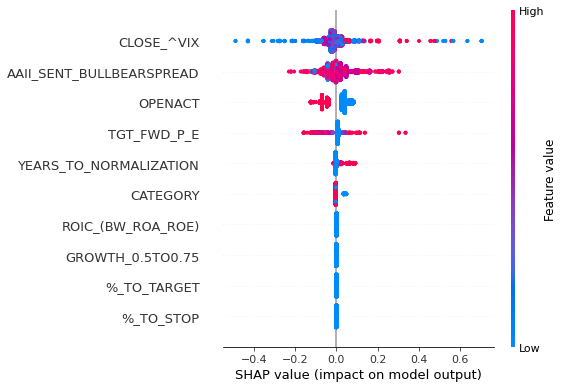

In [11]:
mlflow.end_run()
mlflow.start_run(run_id=runid)

if "pipeline" in str(type(mdl)).lower():
    model_type = "pipeline"

# Create object that can calculate shap values
if model_type == "h2o":
    # print('h2o explanation')
    # h2o_wrapper = H2ORegWrapper(mdl,X.columns)
    # explainer = shap.SamplingExplainer(h2o_wrapper.predict,h2o.H2OFrame(X[0:100]))

    # TODO use lightgbm with astype('category') to create train model
    explainer = sub_gbm(X, y_pred)
elif model_type == "pipeline":
    explainer = shap.Explainer(mdl[-1])
else:
    # assume sklearn etc.
    explainer = shap.Explainer(mdl)

# save expected value
if len(explainer.expected_value.shape) > 0:
    ev = explainer.expected_value[0]
    explainer.expected_value = ev

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
# TODO get rid of sample below
if model_type == "pipeline":
    shap_values = explainer(mdl[0].transform(X))
else:
    shap_values = explainer(X)  # gets full shap_value descriptions

# ensure slicing by column names work
shap_values.feature_names = list(X.columns)

# Make plot. Index of [1] is explained in text below.
# shap.summary_plot(shap_values, X_train)

f = plt.gcf()

# Make plot to save
# shap.summary_plot(shap_values, X,show=False,) # not as informative as beeswarm

# datetime object containing current date and time
now = datetime.now()
dt_string = now.strftime("%d%m%Y_%H%M%S")
print("date and time =", dt_string)

if model_type == "pipeline":
    categorical_names = list(X.select_dtypes(include=["object"]).columns)
    col_idx = list(np.where(np.isin(shap_values.feature_names, categorical_names))[0])

    shap_cat = copy.deepcopy(shap_values)
    shap_cat.data = np.array(shap_values.data, dtype="object")
    res_arr = (
        mdl[0]
        .transformers_[1][1][1]
        .inverse_transform(
            pd.DataFrame(shap_cat.data[:, col_idx], columns=[categorical_names])
        )
    )
    for i, loc in enumerate(col_idx):
        shap_cat.data[:, loc] = res_arr[:, i]

shap.plots.beeswarm(shap_values, show=False)
plt.tight_layout()
plt.savefig(f"summary_plot_{dt_string}.png", bbox_inches="tight")
plt.show()

mlflow.log_metric("expected_val", ev)
mlflow.log_artifact(f"summary_plot_{dt_string}.png")

os.remove(f"summary_plot_{dt_string}.png")

mlflow.end_run()

In [12]:
## save explainer

mlflow.end_run()
mlflow.start_run(run_id=runid)

with open(f"explainer.pkl", "wb") as handle:
    dill.dump(explainer, handle, recurse=True)

mlflow.log_artifact(f"explainer.pkl")

os.remove(f"explainer.pkl")

mlflow.end_run()

In [13]:
## check highest

top_trades = XY_df[XY_df["PCT_RET_FINAL"] > 1]
top_trades.head()

,Unnamed: 0,%_TO_STOP,%_TO_TARGET,AAII_SENT_BEARISH,AAII_SENT_BULLBEARSPREAD,AAII_SENT_BULLISH,AAII_SENT_BULLISH8WEEKMOVAVG,AAII_SENT_BULLISHAVERAGE,AAII_SENT_BULLISHAVERAGE+STDEV,AAII_SENT_BULLISHAVERAGESTDEV,AAII_SENT_DATE,AAII_SENT_NEUTRAL,AAII_SENT_S&P500WEEKLYCLOSE,AAII_SENT_S&P500WEEKLYHIGH,AAII_SENT_S&P500WEEKLYLOW,AAII_SENT_TOTAL,ACTION,AT_PRICE,CASH_CHG_(PNL),CATEGORY,CLOSEACT,CLOSE_DATE,CLOSE_PRICE,CLOSE_^GSPC,CLOSE_^VIX,COMMENTS,COMMENTS.1,COMMISSION,COMM_TOT,COMPANY_NAME_(IN_ALPHABETICAL_ORDER),CURRENT_PRICE,DATE,DATE_,DAYSTOFYEND,DETAILS,EPS1,EPS2,FILENAME,FYEND,FYEPSNXT,GROWTH_0.5TO0.75,LASTUPDATED,OPENACT,OPEN_DATE,OPEN_PRICE,PCTRETURN,PCT_RET_FINAL,PNL,PRICE,QTYCHG,QUANTITY,ROIC_(BW_ROA_ROE),STARTDATE,STOP,SYMBOL,TARGET,TGT_FWD_P_E,TICKER,TIME,UNNAMED:_0,UNNAMED:_0.1,UNNAMED:_0_X,UNNAMED:_0_Y,UNNAMED:_6,UNNAMED:_8,YEARS_TO_NORMALIZATION,weight
6,6,-1,-1,0.487055,-0.271845,0.215210,0.243640,0.383833,0.486856,0.280810,2016-01-21,0.297735,1859.330000,1950.330000,1812.290000,1.0,BOT,_NA_,"($7,781.40)",_NA_,S,2021-06-17 12:40:33,1184.7050,2063.110107,18.23,_NA_,_NA_,1.00,-1.030805,_NA_,_NA_,2015-05-14,2015-06-30,_NA_,-1,_NA_,_NA_,PCM-Tracking - LogHist.csv,_NA_,_NA_,-1,_NA_,B,2015-06-30 00:00:00,579.659697,_NA_,1.043447,3024.22,778.040,10,5,-1,_NA_,_NA_,MKL,_NA_,-1.0,_NA_,9:37:15 AM,6,57,1914,259,USD,_NA_,-1,1
608,608,-1,-1,0.248945,0.029536,0.278481,0.314410,0.383265,0.486165,0.280365,2016-04-14,0.472574,2082.419922,2083.179932,2033.800049,1.0,SLD,_NA_,"$5,937.77",_NA_,S,2018-09-10 15:53:07,1937.0100,2061.719971,14.85,_NA_,_NA_,1.13,-2.379502,_NA_,_NA_,2016-04-12,2016-04-12,_NA_,-1,_NA_,_NA_,PCM-Tracking - LogHist.csv,_NA_,_NA_,-1,_NA_,B,2016-04-12 13:04:47,600.140000,_NA_,2.227137,6682.97,593.890,10,5,-1,_NA_,_NA_,AMZN,_NA_,-1.0,_NA_,10:14:42,608,608,958,247,USD,U1060261,-1,1
705,705,-1,-1,0.340967,-0.147583,0.193384,0.262586,0.383060,0.485866,0.280255,2016-05-19,0.465649,2047.630005,2083.290039,2034.489990,1.0,SLD,_NA_,"$36,126.81",_NA_,S,2018-10-03 14:56:30,232.3027,2064.110107,14.41,_NA_,_NA_,2.39,-2.878473,_NA_,_NA_,2016-05-12,2016-05-12,_NA_,-1,_NA_,_NA_,PCM-Tracking - LogHist.csv,_NA_,_NA_,-1,_NA_,B,2016-05-12 11:47:57,90.209450,_NA_,1.574633,3551.17,90.323,400,25,-1,_NA_,_NA_,AAPL,_NA_,-1.0,_NA_,10:45:03,705,702,979,242,USD,U1060261,-1,1
740,740,-1,-1,0.267574,0.045351,0.312925,0.308201,0.382677,0.485265,0.280089,2016-08-11,0.419501,2175.490000,2187.660000,2152.560000,1.0,BOT,_NA_,"($4,837.00)",_NA_,S,2020-04-21 11:00:08,428.8900,2182.870117,11.39,_NA_,_NA_,1.00,-2.191949,_NA_,_NA_,2016-08-05,2016-08-05,_NA_,-1,_NA_,_NA_,PCM-Tracking - LogHist.csv,_NA_,_NA_,-1,_NA_,B,2016-08-05 10:54:18,96.720000,_NA_,3.433526,4981.36,96.720,50,15,-1,_NA_,_NA_,NFLX,_NA_,-1.0,_NA_,Aug 5 10:54:18,740,741,1434,230,USD,U1060261,-1,1
741,741,-1,-1,0.267574,0.045351,0.312925,0.308201,0.382677,0.485265,0.280089,2016-08-11,0.419501,2175.490000,2187.660000,2152.560000,1.0,BOT,_NA_,"($4,837.00)",_NA_,S,2018-07-13 10:13:51,398.2735,2182.870117,11.39,_NA_,_NA_,1.00,-2.052966,_NA_,_NA_,2016-08-05,2016-08-05,_NA_,-1,_NA_,_NA_,PCM-Tracking - LogHist.csv,_NA_,_NA_,-1,_NA_,B,2016-08-05 10:54:18,96.720000,_NA_,3.116677,3014.45,96.720,50,10,-1,_NA_,_NA_,NFLX,_NA_,-1.0,_NA_,Aug 5 10:54:18,741,740,927,230,USD,U1060261,-1,1


## plot partial dependence for vars

date and time = 20220705_111755


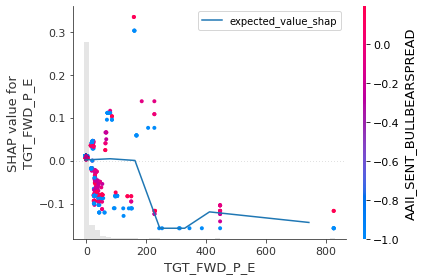

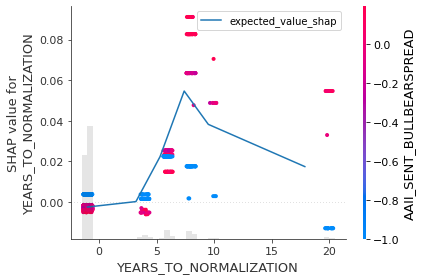

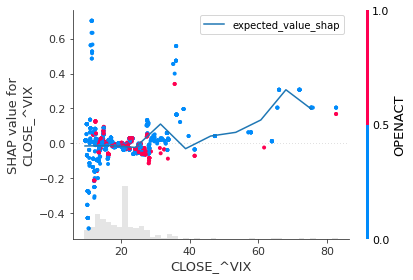

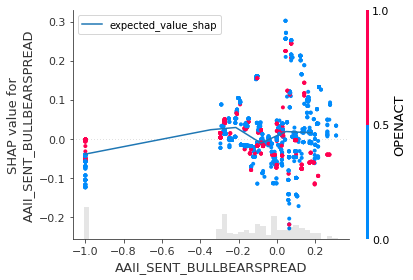

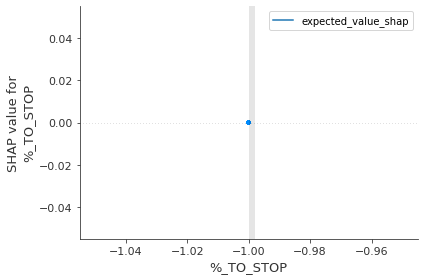

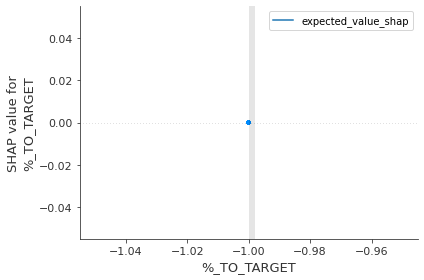

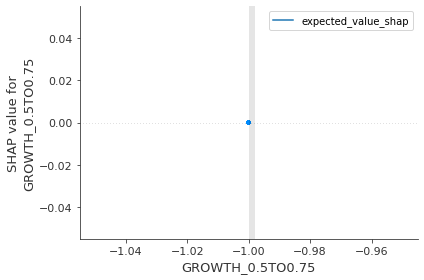

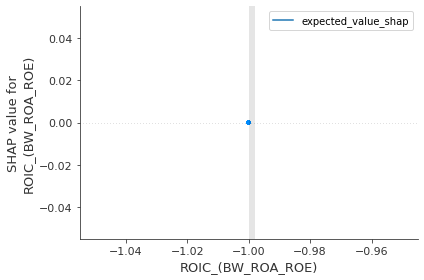

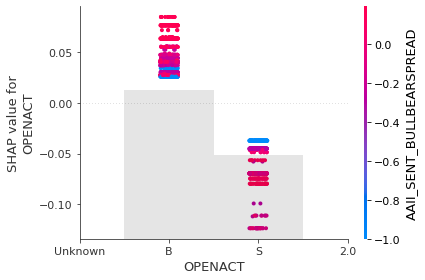

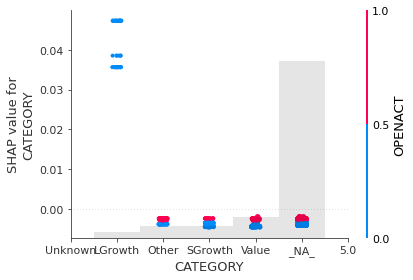

In [14]:
# make plots

mlflow.end_run()
mlflow.start_run(run_id=runid)

# datetime object containing current date and time
now = datetime.now()
dt_string = now.strftime("%Y%m%d_%H%M%S")
print("date and time =", dt_string)

for var in cols_required:
    fig, ax = plt.subplots()

    shap_slice = shap_values[:, var]

    try:
        shap.plots.scatter(shap_slice, ax=ax, show=False, color=shap_values)
    except:
        shap.plots.scatter(shap_slice, ax=ax, show=False)

    if var in categorical_names:

        # get integer labels
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))

        orig_list = ax.get_xticks()
        new_list = np.insert(
            mdl[0].transformers_[1][1][1].categories_[categorical_names.index(var)],
            0,
            "Unknown",
        )

        for i in range(len(orig_list) - len(new_list)):
            try:
                new_list = np.append(new_list, orig_list[i + len(new_list)])
            except:
                pass

        ax.set_xticks(orig_list)
        ax.set_xticklabels(new_list)

    else:
        # deprecated
        # shap.dependence_plot(var, shap_values.values, X, ax=ax, show=False)

        int_labels, col_bins = pd.cut(X[var], bins=10, retbins=True, labels=False)

        shap_col_df = pd.DataFrame(
            {
                var: col_bins[int_labels],
                "expected_value_shap": shap_values.values[:, X.columns.get_loc(var)],
            }
        )

        shap_col_grp_df = shap_col_df.groupby(var).mean()

        shap_col_grp_df.plot(ax=ax)

    # TODO add
    # shap.plots.partial_dependence(var, mdl.predict, X,  model_expected_value=True)
    # f = plt.gcf()

    plt.tight_layout()
    plt.savefig(f"shappdp_{var}_{dt_string}.png", bbox_inches="tight")
    plt.show()

    mlflow.log_artifact(f"shappdp_{var}_{dt_string}.png")

    os.remove(f"shappdp_{var}_{dt_string}.png")

mlflow.end_run()

warning, adjusting shap to match actual


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


(   predicted_ret
 0          0.077,
 .values =
 array([[ 0.00507007, -0.00379557, -0.02111331,  0.0180176 , -0.0018805 ,
         -0.0018805 , -0.0018805 , -0.0018805 ,  0.02863889, -0.00568382]])
 
 .base_values =
 array([0.06338764])
 
 .data =
 array([[-1.        , -1.        , 18.22999954, -0.271845  , -1.        ,
         -1.        , -1.        , -1.        ,  0.        ,  4.        ]]),
    TGT_FWD_P_E  YEARS_TO_NORMALIZATION  CLOSE_^VIX  AAII_SENT_BULLBEARSPREAD  \
 0      0.00507               -0.003796   -0.021113                  0.018018   
 
    %_TO_STOP  %_TO_TARGET  GROWTH_0.5TO0.75  ROIC_(BW_ROA_ROE)   OPENACT  \
 0   -0.00188     -0.00188          -0.00188           -0.00188  0.028639   
 
    CATEGORY  
 0 -0.005684  ,
 <Figure size 576x468 with 3 Axes>)

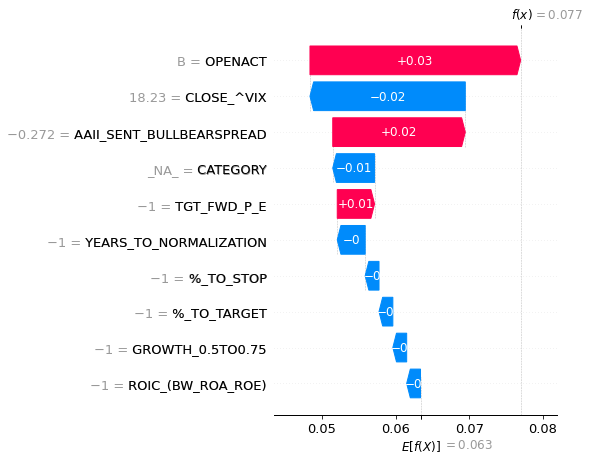

In [15]:
## test waterfallplot

main_file = importlib.import_module("P1-AnalyzeTrades_h_predictresult")

main_file.predict_return(
    mlflow_tracking_uri=mlflow_tracking_uri,
    experiment_name=experiment_name,
    run_id=runid,
    inputs=X.loc[[0], :],
    explain=True,
    show_plot=True,
    preloaded_model=mdl,
)

In [16]:
## end mlflow and h2o

mlflow.end_run()
try:
    h2o.cluster().shutdown(prompt=False)  # if want to end earlier
except:
    pass

In [17]:
## backup functions

# https://scikit-learn.org/stable/auto_examples/linear_model/plot_tweedie_regression_insurance_claims.html
# def gini(actual, pred, sample_weight = None):
#     #ignores weights
#     assert (len(actual) == len(pred))
#     allv = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)
#     allv = allv[np.lexsort((allv[:, 2], -1 * allv[:, 1]))]
#     totalLosses = allv[:, 0].sum()
#     giniSum = allv[:, 0].cumsum().sum() / totalLosses

#     giniSum -= (len(actual) + 1) / 2.
#     return giniSum / len(actual)

# def gini_normalized(truth, predictions, sample_weight=None):
#     return gini(truth, predictions) / gini(truth, truth)

# https://stackoverflow.com/questions/48999542/more-efficient-weighted-gini-coefficient-in-python
# def gini(x, sample_weight=None):
#     # The rest of the code requires numpy arrays.
#     x = np.asarray(x)
#     if sample_weight is not None:
#         w = np.asarray(sample_weight)
#         sorted_indices = np.argsort(x)
#         sorted_x = x[sorted_indices]
#         sorted_w = w[sorted_indices]
#         # Force float dtype to avoid overflows
#         cumw = np.cumsum(sorted_w, dtype=float)
#         cumxw = np.cumsum(sorted_x * sorted_w, dtype=float)
#         return (np.sum(cumxw[1:] * cumw[:-1] - cumxw[:-1] * cumw[1:]) /
#                 (cumxw[-1] * cumw[-1]))
#     else:
#         sorted_x = np.sort(x)
#         n = len(x)
#         cumx = np.cumsum(sorted_x, dtype=float)
#         # The above formula, with all weights equal to 1 simplifies to:
#         return (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n

# def gini_normalized(y_actual, y_pred, sample_weight=None):
#     """
#     Gini coefficient based on two lists and optional weight list, all of same shape
#     """
#     ans = (gini(y_pred , sample_weight=sample_weight)
#            / gini(y_actual , sample_weight=sample_weight)
#     )
#     return ans